In [223]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [224]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [225]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [226]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [227]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [228]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [229]:
#new_distance = lambda den,dist: den/dist

In [230]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [231]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [232]:
year = '2018'

### Get initial point with most density of biomass

In [233]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [234]:
k=10

In [235]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [236]:
weights=set_prob_depots(biomass_density[year])

In [237]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [238]:
biomass_density[year].shape[0]

2418

In [239]:
depots = get_depots(k,year,weights)

### Visualising Data

In [240]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

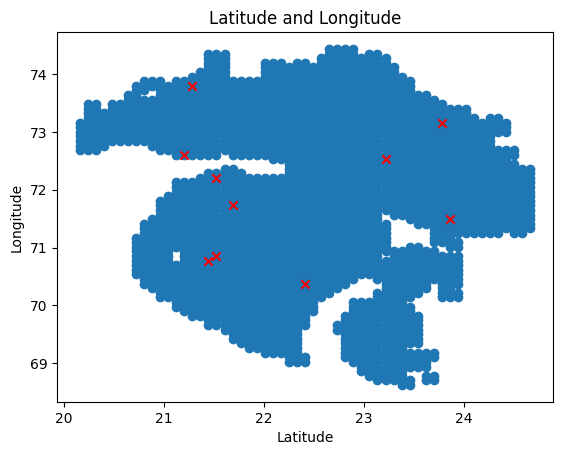

In [241]:
plot_depots(depots)

## Optimal clusters for depots

In [242]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [243]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[355, 1258, 1871, 1912, 2153, 947, 1705, 324, 2117, 2050]
[309, 1257, 1870, 1914, 2300, 1010, 1468, 418, 2115, 1940]
[222, 1321, 1926, 1972, 2323, 1014, 1214, 471, 2017, 1832]
[180, 1386, 1926, 1973, 2322, 954, 1104, 589, 1961, 1777]
[179, 1386, 1869, 2028, 2322, 892, 1050, 589, 1961, 1723]
[179, 1386, 1816, 2078, 2322, 892, 1050, 588, 1961, 1723]
[179, 1386, 1761, 2078, 2322, 892, 1050, 588, 1961, 1723]
Convergence in : 7 iterations


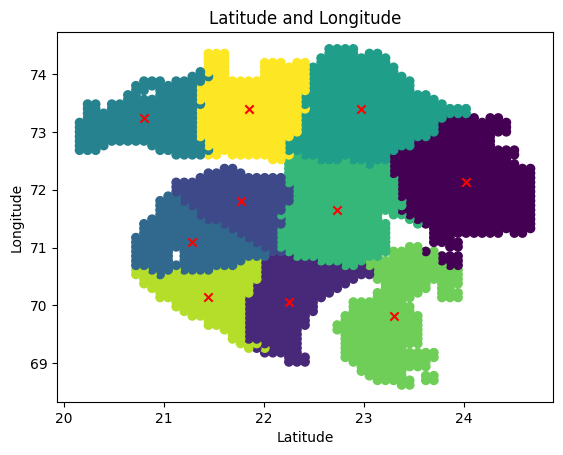

In [244]:
plot_depots(depots,clusters)

## Finding refineries

In [245]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [246]:
def biomass_per_depo(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
        #print(biomass)
    return biomass

In [247]:
biomass_per_depot=biomass_per_depo(k,clusters,year)
biomass_per_depot

[172.79522255699993,
 117.20280542200001,
 103.82896263,
 104.167025724,
 68.89419982000001,
 156.3697560510001,
 179.61224823999981,
 64.79727123230003,
 81.51269607699994,
 125.71345738999997]

In [248]:
depots

[179, 1386, 1761, 2078, 2322, 892, 1050, 588, 1961, 1723]

In [249]:
r=5

In [250]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [251]:
biomass_per_depot

[172.79522255699993,
 117.20280542200001,
 103.82896263,
 104.167025724,
 68.89419982000001,
 156.3697560510001,
 179.61224823999981,
 64.79727123230003,
 81.51269607699994,
 125.71345738999997]

In [252]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.1470730761642041,
 0.0997560978446734,
 0.08837307364730546,
 0.08866081296345331,
 0.058638669214690575,
 0.13309269030213194,
 0.1528753253389951,
 0.05515160584973359,
 0.06937878710464722,
 0.10699986157016528]

In [253]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    #print(refineries_index)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [254]:
get_refineries(5,depots,weights)

[1050, 2322, 1050, 2322, 179]

In [255]:
refineries = get_refineries(r,depots,weights)
refineries

[892, 892, 588, 1761, 1961]

## Optimal clusters for refineries

In [256]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [257]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 4 iterations


In [258]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [259]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

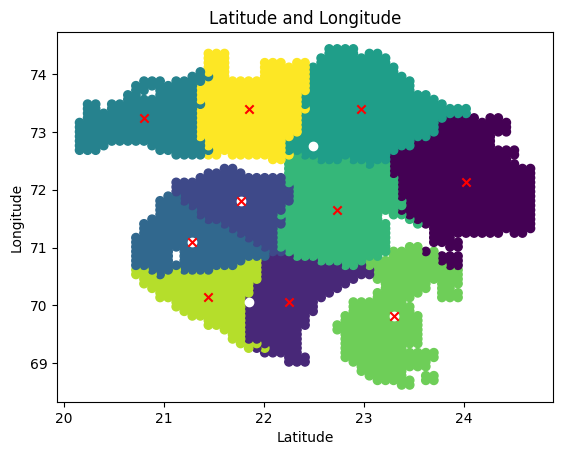

In [260]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [261]:
biomass_per_depot

[172.79522255699993,
 117.20280542200001,
 103.82896263,
 104.167025724,
 68.89419982000001,
 156.3697560510001,
 179.61224823999981,
 64.79727123230003,
 81.51269607699994,
 125.71345738999997]

In [262]:
biomass_per_refinery

[103.82896263,
 104.167025724,
 64.79727123230003,
 198.71550149899997,
 703.3848840579999]

In [263]:
clusters

array([0., 0., 0., ..., 4., 4., 4.])

In [264]:
cluster_depots

array([4., 3., 0., 1., 4., 4., 4., 2., 3., 4.])

In [265]:
depots

[179, 1386, 1761, 2078, 2322, 892, 1050, 588, 1961, 1723]

In [266]:
refineries

[1761, 2078, 588, 1685, 1229]

In [267]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [268]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [269]:
loss_depot(depots,year)

86084.998775723

In [270]:
loss_refinery(refineries,cluster_depots,depots)

399575.6186397284

### Optimal number for depots (2018)

In [271]:
k=range(1,26)

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 3 iterations
Convergence in : 8 iterations
Convergence in : 10 iterations
Convergence in : 12 iterations
Convergence in : 5 iterations
Convergence in : 14 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 15 iterations
Convergence in : 13 iterations
Convergence in : 13 iterations
Convergence in : 9 iterations
Convergence in : 9 iterations
Convergence in : 30 iterations
Convergence in : 22 iterations
Convergence in : 30 iterations
Convergence in : 8 iterations
Convergence in : 11 iterations
Convergence in : 30 iterations
Convergence in : 17 iterations
Convergence in : 8 iterations
Convergence in : 13 iterations
Convergence in : 30 iterations


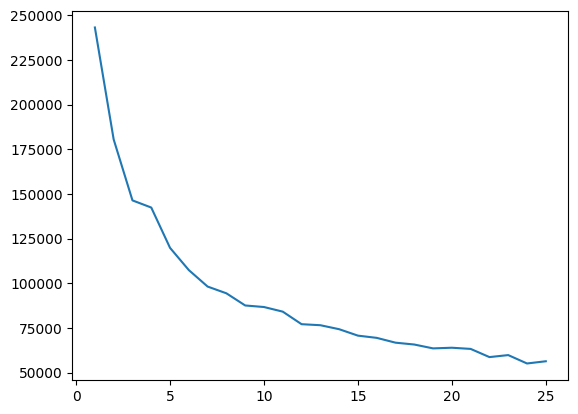

In [272]:
loss_d=[]
year = '2018'
for i in k:
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

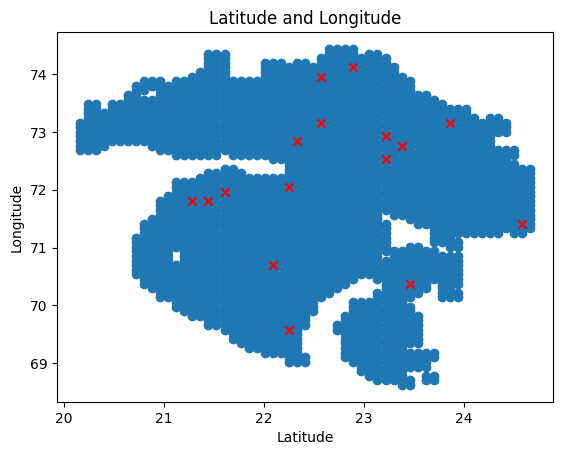

In [273]:
k_2018 = 16
weights = set_prob_depots(density=biomass_density[year])
depots_2018 = get_depots(k_2018,year,weights)
plot_depots(depots_2018)

In [274]:
count=0
clusters_2018=[]
for _ in range(30):
    prev=depots_2018
    depots_2018,clusters_2018=re_cluster_depots(k_2018,biomass_density,depots_2018)
    if np.array_equal(prev,depots_2018):
        break
    print(depots_2018)
    count+=1
print(f"Convergence in : {count} iterations")

[2049, 590, 1489, 1434, 1567, 97, 900, 2213, 1921, 1217, 551, 1638, 1762, 689, 229, 443]
[2189, 589, 1485, 1368, 1626, 123, 900, 2210, 1863, 1105, 609, 1578, 1763, 824, 190, 391]
[2229, 588, 1483, 1434, 1626, 123, 900, 2246, 1863, 1103, 609, 1517, 1763, 824, 190, 348]
[2229, 588, 1482, 1433, 1626, 122, 900, 2206, 1919, 1047, 675, 1456, 1763, 824, 191, 305]
[2229, 588, 1481, 1492, 1626, 122, 900, 2205, 1976, 1045, 744, 1393, 1709, 824, 191, 264]
[2229, 587, 1542, 1553, 1626, 121, 900, 2164, 1976, 1045, 744, 1393, 1654, 824, 230, 222]
[2266, 648, 1543, 1553, 1626, 144, 899, 2118, 2031, 1044, 811, 1393, 1654, 824, 271, 182]
[2266, 647, 1543, 1612, 1567, 168, 962, 2117, 2081, 988, 811, 1393, 1653, 824, 271, 155]
[2265, 646, 1542, 1613, 1566, 207, 962, 2070, 2081, 987, 811, 1393, 1653, 824, 271, 129]
[2265, 646, 1543, 1613, 1566, 206, 962, 2070, 2081, 925, 811, 1393, 1653, 824, 270, 129]
[2265, 645, 1543, 1613, 1566, 245, 962, 2070, 2081, 925, 810, 1394, 1653, 824, 270, 128]
[2265, 645, 154

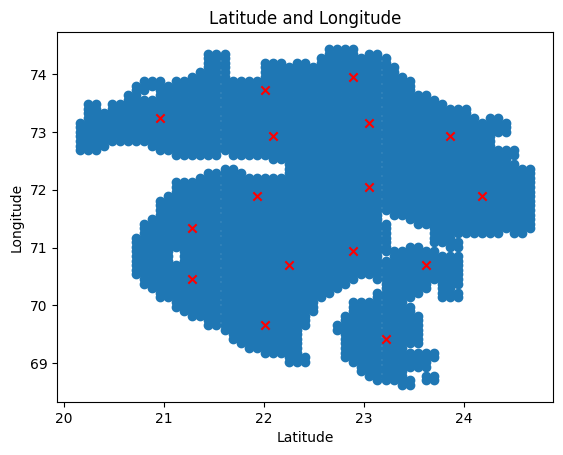

In [275]:
plot_depots(depots_2018)

In [276]:
bpd_2018 = biomass_per_depo(k_2018,clusters_2018,year)

### Optimal Number of refineries (2018)

In [277]:
r = range(1,6)

Convergence in : 1 iterations
Convergence in : 3 iterations
Convergence in : 5 iterations
Convergence in : 2 iterations
Convergence in : 12 iterations


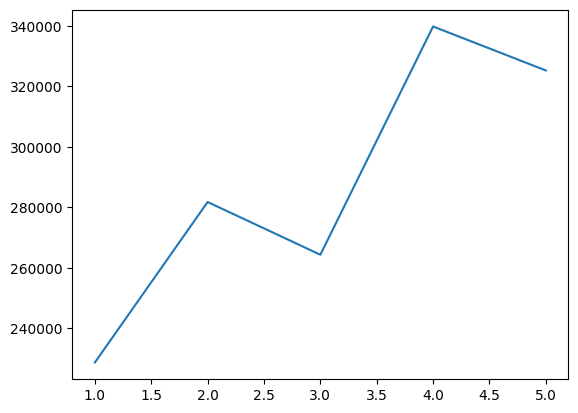

In [278]:
loss_r=[]
year = '2018'
for i in r:
    biomass_per_depot = biomass_per_depo(k_2018,clusters_2018,year)
    weights = set_prob_ref(bpd_2018)
    #print(weights)
    refineries = get_refineries(i,depots_2018,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_2018,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_2018))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [279]:
r_2018 = 3

In [281]:
weights=set_prob_ref(bpd_2018)
refineries_2018 = get_refineries(r_2018,depots_2018,weights)

In [284]:
count=0
clusters_depots_2018=[]
for _ in range(30):
    prev=refineries_2018
    refineries_2018,clusters_depots_2018=re_cluster_refineries(r_2018,depots_2018,refineries_2018)
    if np.array_equal(prev,refineries_2018):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 0 iterations


In [285]:
bpr_2018 = biomass_per_refineries(r_2018,clusters_depots_2018,bpd_2018)

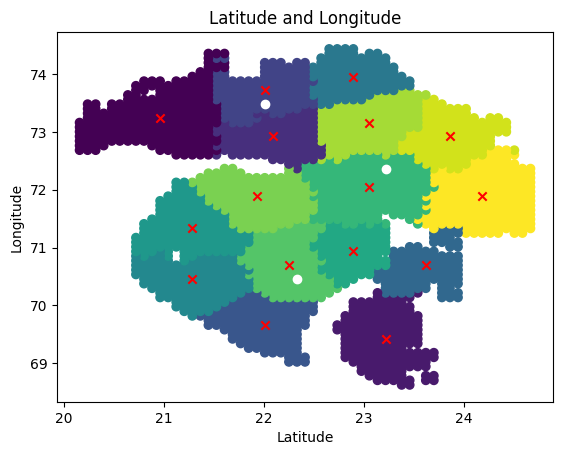

In [290]:
plot_depots(depots_2018,clusters_2018,refineries_2018)

### Optimal number for depots (2019)

In [287]:
k=range(1,26)

In [288]:
year = '2019'

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 7 iterations
Convergence in : 17 iterations
Convergence in : 9 iterations
Convergence in : 11 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 15 iterations
Convergence in : 15 iterations
Convergence in : 21 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 10 iterations
Convergence in : 7 iterations
Convergence in : 10 iterations
Convergence in : 30 iterations
Convergence in : 14 iterations
Convergence in : 7 iterations
Convergence in : 9 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 13 iterations
Convergence in : 30 iterations
Convergence in : 9 iterations


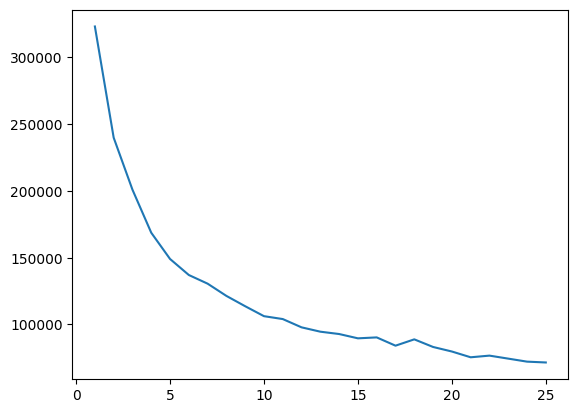

In [289]:
loss_d=[]
year = '2019'
for i in k:

    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

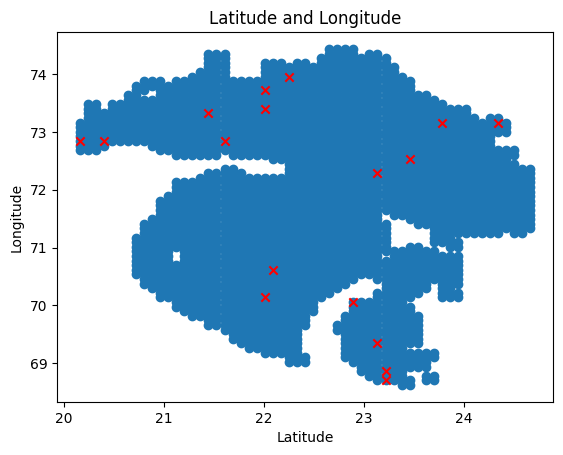

In [291]:
k_2019 = 17
weights = set_prob_depots(density=biomass_density[year])
depots_2019 = get_depots(k_2019,year,weights)
plot_depots(depots_2019)

In [297]:
count=0
clusters_2019=[]
for _ in range(30):
    prev=depots_2019
    depots_2019,clusters_2019 = re_cluster_depots(k_2019,biomass_density,depots_2019)
    if np.array_equal(prev,depots_2019):
        break
    print(depots_2019)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 0 iterations


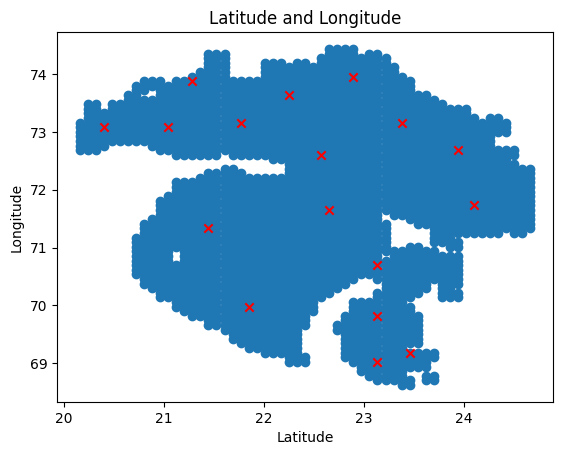

In [298]:
plot_depots(depots_2019)

In [316]:
bpd_2019 = biomass_per_depo(k_2019,clusters_2019,year)

### Optimal Number of refineries (2019)

In [294]:
r = range(1,6)

Convergence in : 1 iterations
Convergence in : 2 iterations
Convergence in : 3 iterations
Convergence in : 2 iterations
Convergence in : 3 iterations


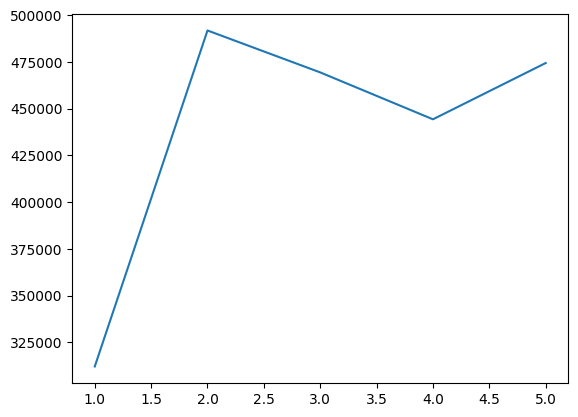

In [299]:
loss_r=[]
for i in r:
    year = '2019'
    biomass_per_depot = biomass_per_depo(k_2019,clusters_2019,year)
    weights = set_prob_ref(bpd_2019)
    #print(weights)
    refineries = get_refineries(i,depots_2019,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_2019,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_2019))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [301]:
r_2019=4

In [302]:
weights = set_prob_ref(bpd_2019)
refineries_2019 = get_refineries(r_2019,depots_2019,weights)

In [303]:
count=0
clusters_depots_2019=[]
for _ in range(30):
    prev=refineries_2019
    refineries_2019,cluster_depots_2019 = re_cluster_refineries(r_2019,depots_2019,refineries_2019)
    if np.array_equal(prev,refineries_2019):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 5 iterations


In [304]:
bpr_2019 = biomass_per_refineries(r_2019,cluster_depots_2019,bpd_2019)

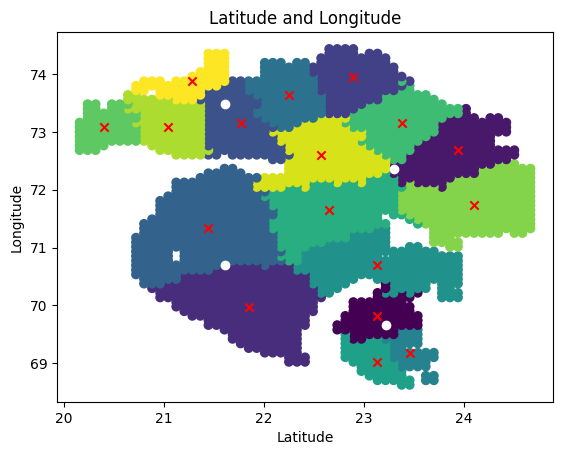

In [305]:
plot_depots(depots_2019,clusters_2019,refineries_2019)

## Combined data for 2018 and 2019

In [307]:
biomass_density['20182019'] = (biomass_density['2018'] + biomass_density['2019']) / 2

In [308]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20182019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740,0.351337
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164,0.426176
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109,0.454360
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641,0.489485
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233,0.383347


### Optimal number for depots (20182019)

In [309]:
k=range(1,26)
year = '20182019'

Convergence in : 1 iterations
Convergence in : 4 iterations
Convergence in : 8 iterations
Convergence in : 14 iterations
Convergence in : 9 iterations
Convergence in : 13 iterations
Convergence in : 7 iterations
Convergence in : 10 iterations
Convergence in : 7 iterations
Convergence in : 8 iterations
Convergence in : 14 iterations
Convergence in : 10 iterations
Convergence in : 6 iterations
Convergence in : 30 iterations
Convergence in : 11 iterations
Convergence in : 30 iterations
Convergence in : 8 iterations
Convergence in : 17 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 8 iterations
Convergence in : 16 iterations
Convergence in : 30 iterations
Convergence in : 6 iterations
Convergence in : 10 iterations


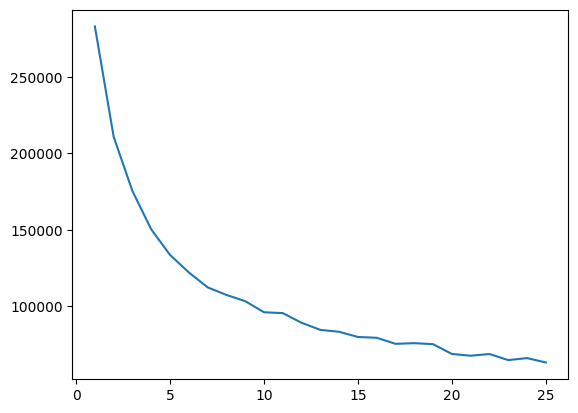

In [310]:
loss_d=[]
for i in k:
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

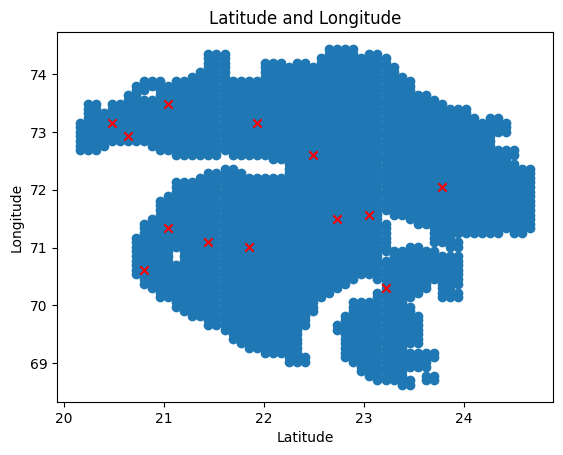

In [311]:
k_1819 = 13
weights = set_prob_depots(density=biomass_density[year])
depots_1819 = get_depots(k_1819,year,weights)
plot_depots(depots_1819)

In [312]:
count=0
clusters_1819=[]
for _ in range(30):
    prev=depots_1819
    depots_1819,clusters_1819=re_cluster_depots(k_1819,biomass_density,depots_1819)
    if np.array_equal(prev,depots_1819):
        break
    print(depots_1819)
    count+=1
print(f"Convergence in : {count} iterations")

[1013, 1157, 2340, 803, 1549, 2386, 1973, 219, 589, 2132, 2151, 1516, 2016]
[890, 1274, 2261, 802, 1549, 2386, 1973, 179, 588, 2086, 2104, 1390, 1902]
[826, 1342, 2185, 867, 1549, 2376, 2027, 179, 588, 2037, 2105, 1389, 1845]
[761, 1409, 2143, 867, 1487, 2376, 2076, 179, 588, 2038, 2057, 1324, 1790]
[761, 1409, 2097, 868, 1427, 2376, 2075, 179, 588, 2037, 2058, 1325, 1736]
[762, 1409, 2048, 869, 1427, 2367, 2075, 179, 588, 2037, 2058, 1326, 1681]
[762, 1409, 1994, 869, 1427, 2367, 2074, 179, 588, 2037, 2058, 1262, 1626]
[762, 1410, 1994, 869, 1427, 2367, 2073, 179, 588, 2036, 2058, 1262, 1626]
[762, 1345, 1994, 869, 1427, 2367, 2073, 179, 588, 2035, 2058, 1263, 1626]
[762, 1345, 1994, 869, 1427, 2367, 2072, 179, 588, 2034, 2058, 1263, 1626]
[762, 1345, 1994, 869, 1427, 2367, 2071, 179, 588, 2034, 2058, 1263, 1567]
[762, 1345, 1994, 869, 1427, 2367, 2071, 179, 588, 2034, 2058, 1263, 1566]
[762, 1345, 1994, 869, 1427, 2367, 2071, 179, 588, 2034, 2058, 1263, 1567]
[762, 1345, 1994, 869, 1

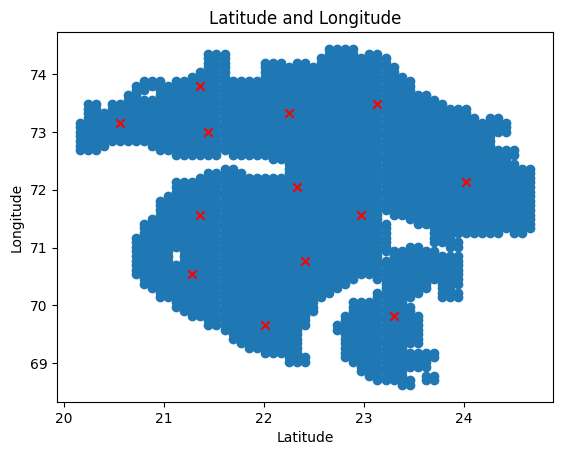

In [313]:
plot_depots(depots_1819)

In [317]:
bpd_1819 = biomass_per_depo(k_1819,clusters_1819,year)

### Optimal Number of refineries (20182019)

In [318]:
r_1819 = range(1,6)

Convergence in : 1 iterations
Convergence in : 2 iterations
Convergence in : 2 iterations
Convergence in : 4 iterations
Convergence in : 4 iterations


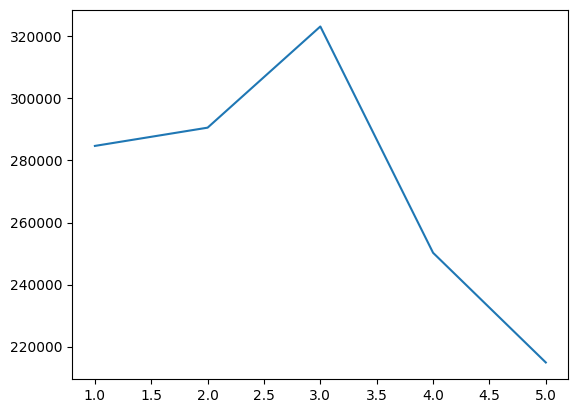

In [320]:
loss_r=[]
year = '20182019'
for i in r:
    weights = set_prob_ref(bpd_1819)
    refineries = get_refineries(i,depots_1819,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_1819,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_1819))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [327]:
r_1819 = 5

In [328]:
weights=set_prob_ref(bpd_1819)
refineries_1819 = get_refineries(r_1819,depots_1819,weights)

In [329]:
count=0
clusters_depots_1819=[]
for _ in range(30):
    prev=refineries_1819
    refineries_1819,cluster_depots_1819 = re_cluster_refineries(r_1819,depots_1819,refineries_1819)
    if np.array_equal(prev,refineries_1819):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 2 iterations


In [331]:
bpr_1819 = biomass_per_refineries(r_1819,cluster_depots_1819,bpd_1819)

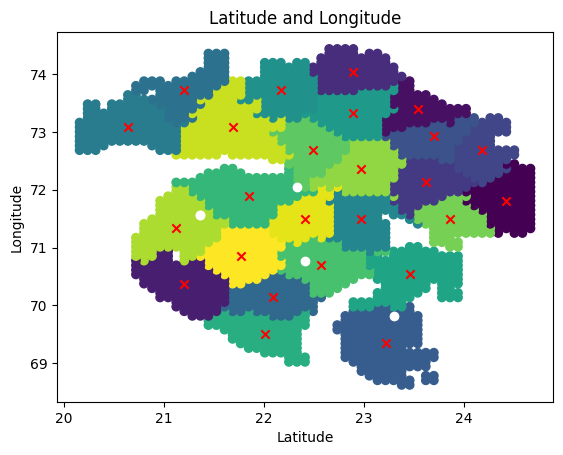

In [332]:
plot_depots(depots,clusters,refineries)

## Submission file pre processing

In [333]:
columns = ['year','data_type','source_index','destination_index','value']

In [334]:
depots_1819

[762, 1345, 1994, 869, 1427, 2367, 2071, 179, 588, 2034, 2058, 1263, 1566]

In [363]:
def preprocessing_depot_1819(depots_1819,columns):
    year=['20182019' for i in range(len(depots_1819))]
    data_type=['depot_location' for i in range(len(depots_1819))]
    destination_index = [None for i in range(len(depots_1819))]
    value = [None for i in range(len(depots_1819))]
    return pd.DataFrame(list(zip(year,data_type,depots_1819,destination_index,value)),columns=columns,index=None)
    

In [364]:
preprocessing_depot_1819(depots_1819,columns)

,year,data_type,source_index,destination_index,value
0,20182019,depot_location,762,None,None
1,20182019,depot_location,1345,None,None
2,20182019,depot_location,1994,None,None
3,20182019,depot_location,869,None,None
4,20182019,depot_location,1427,None,None
5,20182019,depot_location,2367,None,None
6,20182019,depot_location,2071,None,None
7,20182019,depot_location,179,None,None
8,20182019,depot_location,588,None,None
9,20182019,depot_location,2034,None,None


In [365]:
refineries_1819

[1566, 1324, 1707, 553, 1998]

In [372]:
def preprocessing_refineries_1819(refineries_1819,columns):
    year=['20182019' for i in range(len(refineries_1819))]
    data_type=['refinery_location' for i in range(len(refineries_1819))]
    destination_index = [None for i in range(len(refineries_1819))]
    value = [None for i in range(len(refineries_1819))]
    return pd.DataFrame(list(zip(year,data_type,refineries_1819,destination_index,value)),columns=columns,index=None)

In [373]:
preprocessing_refineries_1819(refineries_1819,columns)

,year,data_type,source_index,destination_index,value
0,20182019,refinery_location,1566,None,None
1,20182019,refinery_location,1324,None,None
2,20182019,refinery_location,1707,None,None
3,20182019,refinery_location,553,None,None
4,20182019,refinery_location,1998,None,None
